<a href="https://colab.research.google.com/github/abhistar/DDP_GAN/blob/main/EnsembleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from PIL import Image
from torch.autograd import Variable
import time
import warnings
from matplotlib.ticker import FuncFormatter
import itertools
 
warnings.filterwarnings('ignore')
 
%matplotlib inline

In [ ]:
manual_seed = int(time.time())
print("Random Seed: ", manual_seed)
random.seed(manual_seed)
torch.manual_seed(manual_seed)
 
# location of folder
dataroot = "drive/MyDrive/SuperFolderTrainData"
# number of workers
workers = 2
# batch size for training
batch_size = 30
# image size for input
image_size = 128
# number of channel (1 for BW, 3 for RGB)
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 16
# Size of feature maps in generator
ngf = 128
# Size of feature maps in discriminator
ndf = 128
# Number of training epochs
num_epochs = 50
# Learning rate for optimizers
lr = 0.0005
# Style loss weight
Msl_loss_weight = 0.003
SRsl_loss_weight = 0.015
# Colapse loss weight
Mcl_loss_weight = 0.015
SRcl_loss_weight = 0.002
# Beta values hyperparam for Adam optimizers
beta1 = 0.5
beta2 = 0.99
# Number of GPUs available, currently running on CPU
ngpu = 1
 
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Random Seed:  1624920958
Tesla T4


In [ ]:
# define weights for layer and normalisation
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv')!=-1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm')!=-1:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
 
# setup dataset and data loader
# dataloader for microstructure images
Mdataset = dset.ImageFolder(root=dataroot, transform=transforms.Compose([transforms.Resize(int(image_size/2)), 
                                                                        transforms.CenterCrop(int(image_size/2)),
                                                                        transforms.ToTensor(),
                                                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))
 
Mdataloader = torch.utils.data.DataLoader(Mdataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# dataloader for sr images
SRdataset = dset.ImageFolder(root=dataroot, transform=transforms.Compose([transforms.Resize(image_size), 
                                                                        transforms.CenterCrop(image_size),
                                                                        transforms.ToTensor(),
                                                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))

SRdataloader = torch.utils.data.DataLoader(SRdataset, batch_size=batch_size, shuffle=True, num_workers=workers)

 
device = torch.device("cuda:0" if(torch.cuda.is_available() and ngpu>0) else "cpu")

# **Generator Module**

In [ ]:
class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential()
    
    # input z into convolution
    self.main.add_module('conv1', nn.ConvTranspose2d(nz, ngf*8, 8, 2, 0, bias=False))
    self.main.add_module('btch1', nn.BatchNorm2d(ngf*8))
    self.main.add_module('relu1', nn.ReLU(True))

    # state ngf * 8 * 8
    self.main.add_module('conv2', nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False))
    self.main.add_module('btch2', nn.BatchNorm2d(ngf*4))
    self.main.add_module('relu2', nn.ReLU(True))
            
    # state ngf/2 * 16*16
    self.main.add_module('conv3', nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False))
    self.main.add_module('btch3', nn.BatchNorm2d(ngf*2))
    self.main.add_module('relu3', nn.ReLU(True))
            
    # state ngf/4 * 32*32
    self.main.add_module('conv4', nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False))
    self.main.add_module('btch4', nn.BatchNorm2d(ngf))
    self.main.add_module('relu4', nn.ReLU(True))
            
    # state ngf/8 *64*64
    self.main.add_module('conv5', nn.ConvTranspose2d(ngf, nc, 1, 1, 0, bias=False))
    self.main.add_module('output', nn.Tanh())
        
    #state 3 *64*64
        
  def forward(self, input):
    return self.main(input)

In [ ]:
# Create Generator for producing microstructure images
mGen = Generator(ngpu=ngpu).to(device)
mGen.apply(weights_init)

print(mGen)

Generator(
  (main): Sequential(
    (conv1): ConvTranspose2d(16, 1024, kernel_size=(8, 8), stride=(2, 2), bias=False)
    (btch1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btch2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btch3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (conv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): ReLU(inplace=True)
    (conv5): ConvTranspose2d(128, 3, kernel_size=(1, 1), stride=(1, 1

In [ ]:
class DenseLayer(nn.Module):
  def __init__(self, in_size, growth_rate, bn_size, drop_rate=0.0):
    super(DenseLayer, self).__init__()
    self.bottleneck = nn.Sequential() # define bottleneck layers
    self.bottleneck.add_module('btch1', nn.BatchNorm2d(in_size))
    self.bottleneck.add_module('relu1', nn.ReLU(inplace=True))
    self.bottleneck.add_module('conv1', nn.ConvTranspose2d(in_size, bn_size*growth_rate, kernel_size=1, stride=1, padding=0, bias=False))
 
    self.basic = nn.Sequential() # define basic block
    self.basic.add_module('btch2', nn.BatchNorm2d(bn_size*growth_rate))
    self.basic.add_module('relu2', nn.ReLU(inplace=True))
    self.basic.add_module('conv2', nn.ConvTranspose2d(bn_size*growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False))
 
    self.droprate = drop_rate
 
  def forward(self, input):
    out = self.bottleneck(input)
    if self.droprate > 0:
      out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
    
    out = self.basic(out)
    if self.droprate > 0:
      out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
    return torch.cat((input,out), 1)
 
class TransitionLayer(nn.Module):
  def __init__(self, in_size, out_size, drop_rate=0.0):
    super(TransitionLayer, self).__init__()
    self.trans = nn.Sequential()
    self.trans.add_module('btch', nn.BatchNorm2d(in_size))
    self.trans.add_module('relu', nn.ReLU(inplace=True))
    self.trans.add_module('conv', nn.ConvTranspose2d(in_size, out_size, kernel_size=1, stride=1, padding=0, bias=False))
 
    self.droprate = drop_rate
 
  def forward(self, input):
    out = self.trans(input)
    if self.droprate > 0:
      out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
 
    return out

class DenseBlock(nn.Module):
  def __init__(self, num_layers, in_size, growth_rate, bn_size, droprate=0.0):
    super(DenseBlock, self).__init__()
    self.dblayer = nn.Sequential()
 
    for i in range(num_layers):
      layer = DenseLayer(in_size=(in_size+i*growth_rate), growth_rate=growth_rate, bn_size=bn_size, drop_rate=droprate)
      self.dblayer.add_module('denselayer{}'.format(i+1), layer)
 
  def forward(self, input):
    return self.dblayer(input)

class GenDenseNet(nn.Module):
  def __init__(self, ngpu, growth_rate=12, block_config=(1,2,2,1), in_size=512, bn_size=4, drop_rate=0.0):
    super(GenDenseNet, self).__init__()
    self.ngpu = ngpu
    self.features = nn.Sequential()
    self.features.add_module('btch0', nn.BatchNorm2d(in_size))
 
    num_features = in_size
    for i, num_layers in enumerate(block_config):
      block = DenseBlock(num_layers=num_layers, in_size=num_features, growth_rate=growth_rate, bn_size=bn_size, droprate=drop_rate)
      self.features.add_module('denseblock{}'.format(i+1), block)
      num_features += num_layers*growth_rate
 
      if i!=len(block_config)-1:
        trans = TransitionLayer(in_size=num_features, out_size=num_features*2, drop_rate=drop_rate)
        self.features.add_module('transitionblock{}'.format(i+1), trans)
        num_features *= 2
 
    self.features.add_module('convfinal', nn.ConvTranspose2d(num_features, 3, kernel_size=8, stride=2, padding=3, bias=False))
    self.features.add_module('Tanh', nn.Tanh())
 
  def forward(self, input):
    return self.features(input)

In [ ]:
# Create Generator for producing SR images
srGen = GenDenseNet(ngpu=ngpu, in_size=3).to(device)
srGen.apply(weights_init)

print(srGen)

GenDenseNet(
  (features): Sequential(
    (btch0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (denseblock1): DenseBlock(
      (dblayer): Sequential(
        (denselayer1): DenseLayer(
          (bottleneck): Sequential(
            (btch1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU()
            (conv1): ConvTranspose2d(3, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
          (basic): Sequential(
            (btch2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU()
            (conv2): ConvTranspose2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
        )
      )
    )
    (transitionblock1): TransitionLayer(
      (trans): Sequential(
        (btch): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (conv): 

# **Discriminator Module**

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, ngpu, final_kernel_size=8): #final_kernel_size=8 ->128 | =4 -> 64 image size
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential()

    # input is (nc) *128*128
    self.main.add_module('conv1', nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False))
    self.main.add_module('btch1', nn.BatchNorm2d(ndf))
    self.main.add_module('relu1', nn.LeakyReLU(0.2, inplace=True))

    # input is ndf/8 *64*64
    self.main.add_module('conv2', nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1, bias=False))
    self.main.add_module('btch2', nn.BatchNorm2d(ndf*2))
    self.main.add_module('relu2', nn.LeakyReLU(0.2, inplace=True))

    #input is ndf/4 *32*32
    self.main.add_module('conv3', nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1, bias=False))
    self.main.add_module('btch3', nn.BatchNorm2d(ndf*4))
    self.main.add_module('relu3', nn.LeakyReLU(0.2, inplace=True))

    #input is ndf/2 *16*16
    self.main.add_module('conv4', nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1, bias=False))
    self.main.add_module('btch4', nn.BatchNorm2d(ndf*8))
    self.main.add_module('relu4', nn.LeakyReLU(0.2, inplace=True))

    #input is ndf *8*8
    self.main.add_module('conv5', nn.Conv2d(ndf*8, 1, kernel_size=final_kernel_size, stride=1, padding=0, bias=False))
    self.main.add_module('output', nn.Sigmoid())

  def forward(self, input):
    return self.main(input)

In [ ]:
# Create discriminitor to distinguish microstructure
mDis = Discriminator(ngpu=ngpu, final_kernel_size=4).to(device)
mDis.apply(weights_init)

print(mDis)

Discriminator(
  (main): Sequential(
    (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btch1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btch3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btch4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): LeakyReLU(negative_slope=0.2, i

In [ ]:
# Create discriminator to distinguish SR images
srDis = Discriminator(ngpu=ngpu).to(device)
srDis.apply(weights_init)

print(srDis)

Discriminator(
  (main): Sequential(
    (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btch1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btch3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btch4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): LeakyReLU(negative_slope=0.2, i

## Check for inputs and outputs consistency

In [ ]:
in_tensor = torch.rand(10, 16, 1, 1).to(device)

gen_img = mGen(in_tensor)
print(gen_img.shape)

torch.Size([10, 3, 64, 64])


In [ ]:
sr_img = srGen(gen_img)
print(sr_img.shape)

torch.Size([10, 3, 128, 128])


In [ ]:
mdis_tensor = mDis(gen_img)
print(mdis_tensor.shape)

torch.Size([10, 1, 1, 1])


In [ ]:
srdis_tensor = srDis(sr_img)
print(srdis_tensor.shape)

torch.Size([10, 1, 1, 1])


# **Error Functions and Optimizers**

### Style Loss

In [ ]:
def gram_matrix(input):
  a, b, c, d = input.size() # a=batch size(=1) b=number of feature maps (c,d)=dimensions of a f. map (N=c*d)
  features = input.view(a * b, c * d) # resise F_XL into \hat F_XL
  G = torch.mm(features, features.t()) # compute the gram product
  return G.div(a * b * c * d) # we 'normalize' the values of the gram matrix by dividing by the number of element in each feature maps.

def style_loss(style_layer, combination_layer, num_channels = nc):
  assert style_layer.size()==combination_layer.size(), "Input Sizes do not match in StyleLoss"
  a, b, c, d = style_layer.size() # a=batch size(=1) b=number of feature maps (c,d)=dimensions of a f. map (N=c*d)
  styleloss = 0
  
  for i in range(a):
    S = gram_matrix(torch.unsqueeze(style_layer[i], 0)).detach()
    C = gram_matrix(torch.unsqueeze(combination_layer[i],0)).detach()
    styleloss = torch.add(styleloss, torch.sum(torch.square(S-C)/(2*num_channels*c*d)**2)*3e6)
    styleloss = Variable(styleloss, requires_grad=True)

  return styleloss

def content_loss(content_layer, combination_layer, num_channels = nc):
  assert content_layer.size()==combination_layer.size(), "Input Sizes do not match in Content loss"
  a, b, c, d = content_layer.size()
  ctloss = torch.sum(torch.square(content_layer-combination_layer)/(2*num_channels*c*d)**2)
  ctloss = Variable(ctloss, requires_grad=True)
  return ctloss

def colapse_loss(target_feature):
  z_d_gen = torch.flatten(target_feature).reshape(1,-1)
  nom = torch.mm(z_d_gen, z_d_gen.t())
  denom = torch.sqrt(torch.sum(torch.square(z_d_gen), 1, keepdim=True))
  pt = torch.square(torch.transpose((nom / denom), 1, 0))
  #pt = pt - torch.diag(torch.diag(pt))
  pulling_term = torch.sum(pt) / (batch_size * (batch_size - 1)*4e1)
  pulling_term = Variable(pulling_term, requires_grad=True)

  return pulling_term

vgg19 = models.vgg19(pretrained=True).features.to(device).eval()

def get_vgg_layers(input, model=vgg19, num_layer=4):
  i = 0
  Model = copy.deepcopy(model)
  list_layers = nn.ModuleList()
  module = None
  for layer in Model.children():
    if isinstance(layer, nn.Conv2d):
      i +=1
      name = 'conv{}'.format(i)
      list_layers.append(module)
      module = nn.Sequential()
    elif isinstance(layer, nn.ReLU):
      name = 'relu{}'.format(i)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'btnm{}'.format(i)
    else: 
      raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    module.add_module(name, layer)

    if i >= (num_layer+1):
      break

  outconv1 = list_layers[1](input)
  outconv2 = list_layers[2](outconv1)
  outconv3 = list_layers[3](outconv2)
  outconv4 = list_layers[4](outconv3)

  return outconv1, outconv2, outconv3, outconv4

In [ ]:
def get_style_collapse_loss(style_batch, gen_batch):
  Sconv1, Sconv2, Sconv3, Sconv4 = get_vgg_layers(style_batch)
  Cconv1, Cconv2, Cconv3, Cconv4 = get_vgg_layers(gen_batch)
  
  # style loss
  s1 = style_loss(Sconv1, Cconv1)
  s2 = style_loss(Sconv2, Cconv2)
  s3 = style_loss(Sconv3, Cconv3)
  s4 = style_loss(Sconv4, Cconv4)
  sl_loss = torch.mean(s1+s2+s3+s4)
  
  Cconv = torch.cat((torch.flatten(Cconv1), torch.flatten(Cconv2), torch.flatten(Cconv3), torch.flatten(Cconv4)), 0)
  c = colapse_loss(Cconv)
  cl_loss = torch.mean(c)
  ct_loss = content_loss(Sconv4, Cconv4)
  return sl_loss, cl_loss, ct_loss

### Optimizers and BCE loss

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()
 
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(1, 16, 1, 1, device=device)
 
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.
 
# Setup Adam optimizers for all networks
optimizerMD = optim.Adam(mDis.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0.3)
optimizerSRD = optim.Adam(srDis.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0.3)
optimizerMG = optim.Adam(mGen.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0.3)
optimizerSRG = optim.SGD(srGen.parameters(), lr=lr, momentum=0.9, dampening=0, weight_decay=0.3, nesterov=True)

# **Training Loop**

In [ ]:
mimg_list = [] # stores image produced by mGen
srimg_list = [] # stores image produces by srGen
mGen_loss = [] # stores losses for mGen
srGen_loss = [] # stores losses for srGen
mDis_loss = [] # stores losses for mDis
srDis_loss = [] # stores losses for srDis
mGen_bce = []
srGen_bce = []
iter = 0 # keeps track of total iterations
skip_steps = 5

print('Starting Training')
for epoch in tqdm(range(num_epochs)):
  for (i, mdata), srdata in zip(enumerate(Mdataloader), SRdataloader):
    MDis_real, MDis_fake, SRDis_real, SRDis_fake = 0.0, 0.0, 0.0, 0.0
    errMDis_real, errMDis_fake, errMDis = None, None, None
    errSRDis_real, errSRDis_fake, errSRDis = None, None, None
    ########### Train Discriminators ############3
    if i%skip_steps == 0:
      ############ MDis track ###############
      ############# REAL DATA ###############
      mDis.zero_grad()
      real_mdis_input = mdata[0].to(device)
      b_size = real_mdis_input.size(0)
      label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
      moutput = mDis(real_mdis_input).view(-1)

      errMDis_real = criterion(moutput, label)
      errMDis_real.backward()
      MDis_real = moutput.mean().item()

      ############# FAKE DATA ###############
      noise = torch.randn(b_size, 16, 1, 1, device=device)
      fake_mdis_input = mGen(noise)
      label.fill_(fake_label)
      moutput = mDis(fake_mdis_input.detach()).view(-1)

      errMDis_fake = criterion(moutput, label)
      errMDis_fake.backward()
      MDis_fake = moutput.mean().item()

      ############# OPTIMIZE MDIS ############
      errMDis = errMDis_real + errMDis_fake
      optimizerMD.step()

      ############ SRDis track ##############
      ############# REAL DATA ###############
      srDis.zero_grad()
      real_srdis_input = srdata[0].to(device)
      b_size = real_srdis_input.size(0)
      label.fill_(real_label)
      sroutput = srDis(real_srdis_input).view(-1)

      errSRDis_real = criterion(sroutput, label)
      errSRDis_real.backward()
      SRDis_real = sroutput.mean().item()

      ############# FAKE DATA ###############
      fake_srdis_input = srGen(fake_mdis_input)
      label.fill_(fake_label)
      sroutput = srDis(fake_srdis_input.detach()).view(-1)

      errSRDis_fake = criterion(sroutput, label)
      errSRDis_fake.backward()
      SRDis_fake = sroutput.mean().item()

      ############# OPTIMIZE SRDIS ############
      errSRDis = errSRDis_real + errSRDis_fake
      optimizerSRD.step()

    ############ Gen track ###############
    mGen.zero_grad()
    srGen.zero_grad()

    ############ MGen track ###############
    if i%skip_steps != 0:
      real_mdis_input = mdata[0].to(device)
      label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
      noise = torch.randn(b_size, 16, 1, 1, device=device)
      fake_mdis_input = mGen(noise)
      moutput = mDis(fake_mdis_input.detach()).view(-1)

    else:
      label.fill_(real_label)
      moutput = mDis(fake_mdis_input.detach()).view(-1)

    errMGen_bce = criterion(moutput, label)
    errMGen_bce.backward()

    Msl_loss, Mcl_loss,_ = get_style_collapse_loss(real_mdis_input, fake_mdis_input)
    Msl_loss *= Msl_loss_weight
    Msl_loss.backward()

    Mcl_loss *= Mcl_loss_weight
    Mcl_loss.backward()

    errMGen = errMGen_bce + Msl_loss + Mcl_loss
    optimizerMG.step()

    ############ SRGen track ###############
    if i%skip_steps != 0:
      real_srdis_input = srdata[0].to(device)
      label.fill_(real_label)
      fake_srdis_input = srGen(fake_mdis_input)
      sroutput = srDis(fake_srdis_input.detach()).view(-1)

    else:
      label.fill_(real_label)
      sroutput = srDis(fake_srdis_input.detach()).view(-1)

    errSRGen_bce = criterion(sroutput, label)
    errSRGen_bce.backward()

    SRsl_loss, SRcl_loss, SRct_loss = get_style_collapse_loss(real_srdis_input, fake_srdis_input)

    SRct_loss.backward()
    SRsl_loss *= SRsl_loss_weight
    SRsl_loss.backward()

    SRcl_loss *= SRcl_loss_weight
    SRcl_loss.backward()
    errSRGen = errSRGen_bce + SRsl_loss + SRct_loss + SRcl_loss
    optimizerSRG.step()

    if i%skip_steps == 0:
      mGen_loss.append(errMGen.item())
      srGen_loss.append(errSRGen.item())
      mDis_loss.append(errMDis.item())
      srDis_loss.append(errSRDis.item())
      mGen_bce.append(errMGen_bce.item())
      srGen_bce.append(errSRGen_bce.item())

    if iter%500 == 0:
      with torch.no_grad():
        fakem = mGen(fixed_noise)
      mimg_list.append(fakem.detach().cpu())
      srimg_list.append(srGen(fakem).detach().cpu())
    
    iter += 1

    if i%60 == 0:
      print("[{}/{}]".format(i, len(Mdataloader)))
      print("MDis_real: {:.4f} | MDis_fake: {:.4f} | SRDis_real: {:.4f} | SRDis_fake: {:.4f}".format(MDis_real, MDis_fake, SRDis_real, SRDis_fake))
      print("errMDis: {:.4f} | errMDis_real: {:.4f} | errMDis_fake: {:.4f}".format(errMDis.item(), errMDis_real.item(), errMDis_fake.item()))
      print("errSRDis: {:.4f} | errSRDis_real: {:.4f} | errSRDis_fake: {:.4f}".format(errSRDis.item(), errSRDis_real.item(), errSRDis_fake.item()))
      print("errMGen: {:.4f} | errMGen_bce: {:.4f} | Msl_loss: {:.4f} | Mcl_loss: {:.4f}".format(errMGen.item(), errMGen_bce.item(), Msl_loss.item(), Mcl_loss.item()))
      print("errSRGen: {:.4f} | errSRGen_bce: {:.4f}| SRsl_loss: {:.4f} | SRct_loss: {:.4f} | SRcl_loss: {:.4f}".format(errSRGen.item(), errSRGen_bce.item(), SRsl_loss.item(), SRct_loss.item(), SRcl_loss.item()))
  
  if epoch%25 == 0:
    print("Saving models at epoch: {}".format(epoch))
    torch.save(mGen.state_dict(), '/content/drive/MyDrive/mGen-{}.pt'.format(epoch))
    torch.save(mDis.state_dict(), '/content/drive/MyDrive/mDis-{}.pt'.format(epoch))
    torch.save(srGen.state_dict(), '/content/drive/MyDrive/srGen-{}.pt'.format(epoch))
    torch.save(srDis.state_dict(), '/content/drive/MyDrive/srDis-{}.pt'.format(epoch))

print("Training Finished")









  0%|          | 0/50 [00:00<?, ?it/s]

Starting Training
[0/180]
MDis_real: 0.9463 | MDis_fake: 0.0531 | SRDis_real: 0.9733 | SRDis_fake: 0.0268
errMDis: 0.1097 | errMDis_real: 0.0552 | errMDis_fake: 0.0546
errSRDis: 0.0542 | errSRDis_real: 0.0271 | errSRDis_fake: 0.0271
errMGen: 4.3314 | errMGen_bce: 2.9413 | Msl_loss: 0.8075 | Mcl_loss: 0.5826
errSRGen: 4.2445 | errSRGen_bce: 3.5911| SRsl_loss: 0.0483 | SRct_loss: 0.3065 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9466 | MDis_fake: 0.0531 | SRDis_real: 0.9733 | SRDis_fake: 0.0269
errMDis: 0.1094 | errMDis_real: 0.0548 | errMDis_fake: 0.0546
errSRDis: 0.0543 | errSRDis_real: 0.0271 | errSRDis_fake: 0.0273
errMGen: 4.3396 | errMGen_bce: 2.9373 | Msl_loss: 0.8197 | Mcl_loss: 0.5826
errSRGen: 4.2629 | errSRGen_bce: 3.6169| SRsl_loss: 0.0464 | SRct_loss: 0.3010 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9461 | MDis_fake: 0.0530 | SRDis_real: 0.9737 | SRDis_fake: 0.0268
errMDis: 0.1098 | errMDis_real: 0.0554 | errMDis_fake: 0.0544
errSRDis: 0.0538 | errSRDis_real: 0.0267 | errSRD









  2%|▏         | 1/50 [01:24<1:09:03, 84.57s/it]

[0/180]
MDis_real: 0.9467 | MDis_fake: 0.0531 | SRDis_real: 0.9737 | SRDis_fake: 0.0268
errMDis: 0.1093 | errMDis_real: 0.0548 | errMDis_fake: 0.0545
errSRDis: 0.0539 | errSRDis_real: 0.0267 | errSRDis_fake: 0.0272
errMGen: 4.3983 | errMGen_bce: 2.9385 | Msl_loss: 0.8772 | Mcl_loss: 0.5826
errSRGen: 4.2647 | errSRGen_bce: 3.6190| SRsl_loss: 0.0465 | SRct_loss: 0.3006 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9468 | MDis_fake: 0.0529 | SRDis_real: 0.9737 | SRDis_fake: 0.0268
errMDis: 0.1090 | errMDis_real: 0.0546 | errMDis_fake: 0.0544
errSRDis: 0.0538 | errSRDis_real: 0.0266 | errSRDis_fake: 0.0272
errMGen: 4.3436 | errMGen_bce: 2.9377 | Msl_loss: 0.8233 | Mcl_loss: 0.5826
errSRGen: 4.2712 | errSRGen_bce: 3.6180| SRsl_loss: 0.0483 | SRct_loss: 0.3063 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9468 | MDis_fake: 0.0530 | SRDis_real: 0.9738 | SRDis_fake: 0.0269
errMDis: 0.1092 | errMDis_real: 0.0547 | errMDis_fake: 0.0545
errSRDis: 0.0538 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0273
er









  4%|▍         | 2/50 [02:49<1:07:38, 84.55s/it]

[0/180]
MDis_real: 0.9466 | MDis_fake: 0.0530 | SRDis_real: 0.9737 | SRDis_fake: 0.0269
errMDis: 0.1093 | errMDis_real: 0.0549 | errMDis_fake: 0.0544
errSRDis: 0.0539 | errSRDis_real: 0.0266 | errSRDis_fake: 0.0272
errMGen: 4.3557 | errMGen_bce: 2.9364 | Msl_loss: 0.8367 | Mcl_loss: 0.5826
errSRGen: 4.2587 | errSRGen_bce: 3.6157| SRsl_loss: 0.0460 | SRct_loss: 0.2984 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9468 | MDis_fake: 0.0532 | SRDis_real: 0.9737 | SRDis_fake: 0.0268
errMDis: 0.1093 | errMDis_real: 0.0546 | errMDis_fake: 0.0547
errSRDis: 0.0539 | errSRDis_real: 0.0267 | errSRDis_fake: 0.0272
errMGen: 4.3036 | errMGen_bce: 2.9309 | Msl_loss: 0.7900 | Mcl_loss: 0.5826
errSRGen: 4.2707 | errSRGen_bce: 3.6185| SRsl_loss: 0.0484 | SRct_loss: 0.3052 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9469 | MDis_fake: 0.0532 | SRDis_real: 0.9737 | SRDis_fake: 0.0268
errMDis: 0.1092 | errMDis_real: 0.0546 | errMDis_fake: 0.0546
errSRDis: 0.0538 | errSRDis_real: 0.0266 | errSRDis_fake: 0.0272
er









  6%|▌         | 3/50 [04:13<1:06:07, 84.42s/it]

[0/180]
MDis_real: 0.9470 | MDis_fake: 0.0528 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1088 | errMDis_real: 0.0545 | errMDis_fake: 0.0543
errSRDis: 0.0538 | errSRDis_real: 0.0266 | errSRDis_fake: 0.0272
errMGen: 4.2929 | errMGen_bce: 2.9412 | Msl_loss: 0.7690 | Mcl_loss: 0.5826
errSRGen: 4.2686 | errSRGen_bce: 3.6185| SRsl_loss: 0.0475 | SRct_loss: 0.3040 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9469 | MDis_fake: 0.0529 | SRDis_real: 0.9737 | SRDis_fake: 0.0269
errMDis: 0.1089 | errMDis_real: 0.0546 | errMDis_fake: 0.0543
errSRDis: 0.0538 | errSRDis_real: 0.0266 | errSRDis_fake: 0.0272
errMGen: 4.3680 | errMGen_bce: 2.9393 | Msl_loss: 0.8461 | Mcl_loss: 0.5826
errSRGen: 4.2653 | errSRGen_bce: 3.6172| SRsl_loss: 0.0470 | SRct_loss: 0.3025 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9469 | MDis_fake: 0.0529 | SRDis_real: 0.9737 | SRDis_fake: 0.0268
errMDis: 0.1089 | errMDis_real: 0.0545 | errMDis_fake: 0.0544
errSRDis: 0.0539 | errSRDis_real: 0.0267 | errSRDis_fake: 0.0272
er









  8%|▊         | 4/50 [05:37<1:04:36, 84.27s/it]

[0/180]
MDis_real: 0.9470 | MDis_fake: 0.0530 | SRDis_real: 0.9738 | SRDis_fake: 0.0269
errMDis: 0.1089 | errMDis_real: 0.0545 | errMDis_fake: 0.0544
errSRDis: 0.0538 | errSRDis_real: 0.0266 | errSRDis_fake: 0.0273
errMGen: 4.2587 | errMGen_bce: 2.9383 | Msl_loss: 0.7377 | Mcl_loss: 0.5826
errSRGen: 4.2642 | errSRGen_bce: 3.6153| SRsl_loss: 0.0471 | SRct_loss: 0.3032 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9470 | MDis_fake: 0.0529 | SRDis_real: 0.9737 | SRDis_fake: 0.0269
errMDis: 0.1088 | errMDis_real: 0.0545 | errMDis_fake: 0.0544
errSRDis: 0.0538 | errSRDis_real: 0.0266 | errSRDis_fake: 0.0272
errMGen: 4.3208 | errMGen_bce: 2.9387 | Msl_loss: 0.7994 | Mcl_loss: 0.5826
errSRGen: 4.2600 | errSRGen_bce: 3.6181| SRsl_loss: 0.0456 | SRct_loss: 0.2978 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9470 | MDis_fake: 0.0529 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1088 | errMDis_real: 0.0544 | errMDis_fake: 0.0543
errSRDis: 0.0537 | errSRDis_real: 0.0266 | errSRDis_fake: 0.0272
er









 10%|█         | 5/50 [07:01<1:03:10, 84.24s/it]

[0/180]
MDis_real: 0.9470 | MDis_fake: 0.0529 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1088 | errMDis_real: 0.0545 | errMDis_fake: 0.0543
errSRDis: 0.0538 | errSRDis_real: 0.0266 | errSRDis_fake: 0.0272
errMGen: 4.3692 | errMGen_bce: 2.9390 | Msl_loss: 0.8476 | Mcl_loss: 0.5826
errSRGen: 4.2793 | errSRGen_bce: 3.6195| SRsl_loss: 0.0499 | SRct_loss: 0.3114 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9470 | MDis_fake: 0.0530 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1089 | errMDis_real: 0.0545 | errMDis_fake: 0.0544
errSRDis: 0.0537 | errSRDis_real: 0.0266 | errSRDis_fake: 0.0272
errMGen: 4.3276 | errMGen_bce: 2.9382 | Msl_loss: 0.8068 | Mcl_loss: 0.5826
errSRGen: 4.2559 | errSRGen_bce: 3.6187| SRsl_loss: 0.0448 | SRct_loss: 0.2938 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9470 | MDis_fake: 0.0529 | SRDis_real: 0.9738 | SRDis_fake: 0.0269
errMDis: 0.1088 | errMDis_real: 0.0545 | errMDis_fake: 0.0544
errSRDis: 0.0538 | errSRDis_real: 0.0266 | errSRDis_fake: 0.0272
er









 12%|█▏        | 6/50 [08:25<1:01:41, 84.12s/it]

[0/180]
MDis_real: 0.9470 | MDis_fake: 0.0529 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1088 | errMDis_real: 0.0544 | errMDis_fake: 0.0543
errSRDis: 0.0537 | errSRDis_real: 0.0266 | errSRDis_fake: 0.0271
errMGen: 4.3245 | errMGen_bce: 2.9400 | Msl_loss: 0.8019 | Mcl_loss: 0.5826
errSRGen: 4.2723 | errSRGen_bce: 3.6193| SRsl_loss: 0.0479 | SRct_loss: 0.3065 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9470 | MDis_fake: 0.0529 | SRDis_real: 0.9738 | SRDis_fake: 0.0269
errMDis: 0.1088 | errMDis_real: 0.0544 | errMDis_fake: 0.0544
errSRDis: 0.0538 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
errMGen: 4.2633 | errMGen_bce: 2.9387 | Msl_loss: 0.7419 | Mcl_loss: 0.5826
errSRGen: 4.2569 | errSRGen_bce: 3.6161| SRsl_loss: 0.0453 | SRct_loss: 0.2969 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9470 | MDis_fake: 0.0528 | SRDis_real: 0.9738 | SRDis_fake: 0.0269
errMDis: 0.1087 | errMDis_real: 0.0544 | errMDis_fake: 0.0543
errSRDis: 0.0538 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
er









 14%|█▍        | 7/50 [09:48<1:00:09, 83.95s/it]

[0/180]
MDis_real: 0.9470 | MDis_fake: 0.0528 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1087 | errMDis_real: 0.0545 | errMDis_fake: 0.0543
errSRDis: 0.0537 | errSRDis_real: 0.0266 | errSRDis_fake: 0.0272
errMGen: 4.3303 | errMGen_bce: 2.9397 | Msl_loss: 0.8079 | Mcl_loss: 0.5826
errSRGen: 4.2734 | errSRGen_bce: 3.6182| SRsl_loss: 0.0487 | SRct_loss: 0.3079 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9470 | MDis_fake: 0.0529 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1088 | errMDis_real: 0.0544 | errMDis_fake: 0.0543
errSRDis: 0.0537 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
errMGen: 4.3178 | errMGen_bce: 2.9407 | Msl_loss: 0.7944 | Mcl_loss: 0.5826
errSRGen: 4.2636 | errSRGen_bce: 3.6185| SRsl_loss: 0.0465 | SRct_loss: 0.3000 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9470 | MDis_fake: 0.0528 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1087 | errMDis_real: 0.0544 | errMDis_fake: 0.0543
errSRDis: 0.0537 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
er









 16%|█▌        | 8/50 [11:12<58:45, 83.95s/it]  

[0/180]
MDis_real: 0.9470 | MDis_fake: 0.0529 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1088 | errMDis_real: 0.0545 | errMDis_fake: 0.0543
errSRDis: 0.0537 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
errMGen: 4.3325 | errMGen_bce: 2.9403 | Msl_loss: 0.8096 | Mcl_loss: 0.5826
errSRGen: 4.2754 | errSRGen_bce: 3.6184| SRsl_loss: 0.0494 | SRct_loss: 0.3089 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9470 | MDis_fake: 0.0528 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1087 | errMDis_real: 0.0544 | errMDis_fake: 0.0543
errSRDis: 0.0537 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
errMGen: 4.3472 | errMGen_bce: 2.9397 | Msl_loss: 0.8249 | Mcl_loss: 0.5826
errSRGen: 4.2731 | errSRGen_bce: 3.6200| SRsl_loss: 0.0483 | SRct_loss: 0.3063 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9470 | MDis_fake: 0.0528 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1087 | errMDis_real: 0.0545 | errMDis_fake: 0.0543
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
er









 18%|█▊        | 9/50 [12:36<57:21, 83.95s/it]

[0/180]
MDis_real: 0.9470 | MDis_fake: 0.0528 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1087 | errMDis_real: 0.0544 | errMDis_fake: 0.0543
errSRDis: 0.0537 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.4054 | errMGen_bce: 2.9397 | Msl_loss: 0.8830 | Mcl_loss: 0.5826
errSRGen: 4.2568 | errSRGen_bce: 3.6183| SRsl_loss: 0.0452 | SRct_loss: 0.2947 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9471 | MDis_fake: 0.0528 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1086 | errMDis_real: 0.0544 | errMDis_fake: 0.0543
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
errMGen: 4.3103 | errMGen_bce: 2.9411 | Msl_loss: 0.7865 | Mcl_loss: 0.5826
errSRGen: 4.2599 | errSRGen_bce: 3.6202| SRsl_loss: 0.0450 | SRct_loss: 0.2962 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9471 | MDis_fake: 0.0528 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1087 | errMDis_real: 0.0544 | errMDis_fake: 0.0543
errSRDis: 0.0536 | errSRDis_real: 0.0264 | errSRDis_fake: 0.0271
er









 20%|██        | 10/50 [14:00<55:59, 83.99s/it]

[0/180]
MDis_real: 0.9471 | MDis_fake: 0.0528 | SRDis_real: 0.9739 | SRDis_fake: 0.0267
errMDis: 0.1085 | errMDis_real: 0.0543 | errMDis_fake: 0.0542
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.2878 | errMGen_bce: 2.9421 | Msl_loss: 0.7631 | Mcl_loss: 0.5826
errSRGen: 4.2829 | errSRGen_bce: 3.6209| SRsl_loss: 0.0502 | SRct_loss: 0.3132 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9471 | MDis_fake: 0.0528 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1086 | errMDis_real: 0.0544 | errMDis_fake: 0.0543
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
errMGen: 4.3250 | errMGen_bce: 2.9405 | Msl_loss: 0.8019 | Mcl_loss: 0.5826
errSRGen: 4.2592 | errSRGen_bce: 3.6199| SRsl_loss: 0.0451 | SRct_loss: 0.2956 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9471 | MDis_fake: 0.0528 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1085 | errMDis_real: 0.0543 | errMDis_fake: 0.0542
errSRDis: 0.0537 | errSRDis_real: 0.0266 | errSRDis_fake: 0.0271
er









 22%|██▏       | 11/50 [15:24<54:36, 84.00s/it]

[0/180]
MDis_real: 0.9472 | MDis_fake: 0.0528 | SRDis_real: 0.9740 | SRDis_fake: 0.0268
errMDis: 0.1085 | errMDis_real: 0.0543 | errMDis_fake: 0.0542
errSRDis: 0.0536 | errSRDis_real: 0.0264 | errSRDis_fake: 0.0272
errMGen: 4.2943 | errMGen_bce: 2.9410 | Msl_loss: 0.7707 | Mcl_loss: 0.5826
errSRGen: 4.2769 | errSRGen_bce: 3.6179| SRsl_loss: 0.0498 | SRct_loss: 0.3106 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9471 | MDis_fake: 0.0528 | SRDis_real: 0.9740 | SRDis_fake: 0.0268
errMDis: 0.1085 | errMDis_real: 0.0543 | errMDis_fake: 0.0542
errSRDis: 0.0535 | errSRDis_real: 0.0264 | errSRDis_fake: 0.0271
errMGen: 4.2745 | errMGen_bce: 2.9419 | Msl_loss: 0.7500 | Mcl_loss: 0.5826
errSRGen: 4.2732 | errSRGen_bce: 3.6211| SRsl_loss: 0.0479 | SRct_loss: 0.3055 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9472 | MDis_fake: 0.0528 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1085 | errMDis_real: 0.0543 | errMDis_fake: 0.0542
errSRDis: 0.0536 | errSRDis_real: 0.0264 | errSRDis_fake: 0.0271
er









 24%|██▍       | 12/50 [16:48<53:14, 84.08s/it]

[0/180]
MDis_real: 0.9472 | MDis_fake: 0.0527 | SRDis_real: 0.9739 | SRDis_fake: 0.0267
errMDis: 0.1084 | errMDis_real: 0.0542 | errMDis_fake: 0.0542
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.3542 | errMGen_bce: 2.9418 | Msl_loss: 0.8298 | Mcl_loss: 0.5826
errSRGen: 4.2640 | errSRGen_bce: 3.6225| SRsl_loss: 0.0455 | SRct_loss: 0.2974 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9472 | MDis_fake: 0.0528 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1084 | errMDis_real: 0.0542 | errMDis_fake: 0.0542
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.3626 | errMGen_bce: 2.9416 | Msl_loss: 0.8384 | Mcl_loss: 0.5826
errSRGen: 4.2661 | errSRGen_bce: 3.6211| SRsl_loss: 0.0463 | SRct_loss: 0.3002 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9472 | MDis_fake: 0.0528 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1085 | errMDis_real: 0.0542 | errMDis_fake: 0.0543
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
er









 26%|██▌       | 13/50 [18:12<51:45, 83.92s/it]

[0/180]
MDis_real: 0.9472 | MDis_fake: 0.0527 | SRDis_real: 0.9738 | SRDis_fake: 0.0267
errMDis: 0.1084 | errMDis_real: 0.0542 | errMDis_fake: 0.0542
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.2791 | errMGen_bce: 2.9422 | Msl_loss: 0.7543 | Mcl_loss: 0.5826
errSRGen: 4.2801 | errSRGen_bce: 3.6216| SRsl_loss: 0.0494 | SRct_loss: 0.3105 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9472 | MDis_fake: 0.0528 | SRDis_real: 0.9739 | SRDis_fake: 0.0267
errMDis: 0.1085 | errMDis_real: 0.0542 | errMDis_fake: 0.0543
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.3428 | errMGen_bce: 2.9408 | Msl_loss: 0.8193 | Mcl_loss: 0.5826
errSRGen: 4.2645 | errSRGen_bce: 3.6215| SRsl_loss: 0.0460 | SRct_loss: 0.2984 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9473 | MDis_fake: 0.0527 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1083 | errMDis_real: 0.0541 | errMDis_fake: 0.0542
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
er









 28%|██▊       | 14/50 [19:36<50:20, 83.92s/it]

[0/180]
MDis_real: 0.9473 | MDis_fake: 0.0528 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1084 | errMDis_real: 0.0542 | errMDis_fake: 0.0542
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.2541 | errMGen_bce: 2.9420 | Msl_loss: 0.7295 | Mcl_loss: 0.5826
errSRGen: 4.2499 | errSRGen_bce: 3.6196| SRsl_loss: 0.0433 | SRct_loss: 0.2883 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9472 | MDis_fake: 0.0528 | SRDis_real: 0.9739 | SRDis_fake: 0.0267
errMDis: 0.1084 | errMDis_real: 0.0542 | errMDis_fake: 0.0542
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.3242 | errMGen_bce: 2.9418 | Msl_loss: 0.7997 | Mcl_loss: 0.5826
errSRGen: 4.2631 | errSRGen_bce: 3.6214| SRsl_loss: 0.0457 | SRct_loss: 0.2975 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9472 | MDis_fake: 0.0528 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1085 | errMDis_real: 0.0543 | errMDis_fake: 0.0542
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
er









 30%|███       | 15/50 [21:00<48:55, 83.88s/it]

[0/180]
MDis_real: 0.9472 | MDis_fake: 0.0527 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1084 | errMDis_real: 0.0542 | errMDis_fake: 0.0542
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.3820 | errMGen_bce: 2.9424 | Msl_loss: 0.8569 | Mcl_loss: 0.5826
errSRGen: 4.2796 | errSRGen_bce: 3.6217| SRsl_loss: 0.0496 | SRct_loss: 0.3097 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9472 | MDis_fake: 0.0528 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1085 | errMDis_real: 0.0542 | errMDis_fake: 0.0542
errSRDis: 0.0537 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
errMGen: 4.3365 | errMGen_bce: 2.9415 | Msl_loss: 0.8124 | Mcl_loss: 0.5826
errSRGen: 4.2629 | errSRGen_bce: 3.6207| SRsl_loss: 0.0459 | SRct_loss: 0.2977 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9473 | MDis_fake: 0.0527 | SRDis_real: 0.9737 | SRDis_fake: 0.0268
errMDis: 0.1083 | errMDis_real: 0.0542 | errMDis_fake: 0.0542
errSRDis: 0.0538 | errSRDis_real: 0.0267 | errSRDis_fake: 0.0271
er









 32%|███▏      | 16/50 [22:23<47:30, 83.83s/it]

[0/180]
MDis_real: 0.9473 | MDis_fake: 0.0528 | SRDis_real: 0.9738 | SRDis_fake: 0.0266
errMDis: 0.1084 | errMDis_real: 0.0542 | errMDis_fake: 0.0542
errSRDis: 0.0535 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0270
errMGen: 4.3303 | errMGen_bce: 2.9420 | Msl_loss: 0.8056 | Mcl_loss: 0.5826
errSRGen: 4.2852 | errSRGen_bce: 3.6235| SRsl_loss: 0.0504 | SRct_loss: 0.3128 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9472 | MDis_fake: 0.0528 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1084 | errMDis_real: 0.0542 | errMDis_fake: 0.0542
errSRDis: 0.0536 | errSRDis_real: 0.0264 | errSRDis_fake: 0.0272
errMGen: 4.4240 | errMGen_bce: 2.9419 | Msl_loss: 0.8995 | Mcl_loss: 0.5826
errSRGen: 4.2802 | errSRGen_bce: 3.6183| SRsl_loss: 0.0504 | SRct_loss: 0.3129 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9472 | MDis_fake: 0.0527 | SRDis_real: 0.9727 | SRDis_fake: 0.0266
errMDis: 0.1084 | errMDis_real: 0.0542 | errMDis_fake: 0.0542
errSRDis: 0.0547 | errSRDis_real: 0.0277 | errSRDis_fake: 0.0270
er









 34%|███▍      | 17/50 [23:47<46:02, 83.72s/it]

[0/180]
MDis_real: 0.9472 | MDis_fake: 0.0528 | SRDis_real: 0.9711 | SRDis_fake: 0.0270
errMDis: 0.1085 | errMDis_real: 0.0543 | errMDis_fake: 0.0542
errSRDis: 0.0567 | errSRDis_real: 0.0293 | errSRDis_fake: 0.0274
errMGen: 4.3612 | errMGen_bce: 2.9422 | Msl_loss: 0.8364 | Mcl_loss: 0.5826
errSRGen: 4.2426 | errSRGen_bce: 3.6060| SRsl_loss: 0.0442 | SRct_loss: 0.2937 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9473 | MDis_fake: 0.0527 | SRDis_real: 0.9731 | SRDis_fake: 0.0238
errMDis: 0.1083 | errMDis_real: 0.0542 | errMDis_fake: 0.0541
errSRDis: 0.0516 | errSRDis_real: 0.0276 | errSRDis_fake: 0.0241
errMGen: 4.3058 | errMGen_bce: 2.9429 | Msl_loss: 0.7802 | Mcl_loss: 0.5826
errSRGen: 4.3980 | errSRGen_bce: 3.7521| SRsl_loss: 0.0465 | SRct_loss: 0.3008 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9472 | MDis_fake: 0.0528 | SRDis_real: 0.9752 | SRDis_fake: 0.0278
errMDis: 0.1085 | errMDis_real: 0.0543 | errMDis_fake: 0.0542
errSRDis: 0.0534 | errSRDis_real: 0.0252 | errSRDis_fake: 0.0282
er









 36%|███▌      | 18/50 [25:11<44:38, 83.70s/it]

[0/180]
MDis_real: 0.9472 | MDis_fake: 0.0527 | SRDis_real: 0.9728 | SRDis_fake: 0.0262
errMDis: 0.1084 | errMDis_real: 0.0542 | errMDis_fake: 0.0542
errSRDis: 0.0541 | errSRDis_real: 0.0276 | errSRDis_fake: 0.0265
errMGen: 4.3569 | errMGen_bce: 2.9426 | Msl_loss: 0.8317 | Mcl_loss: 0.5826
errSRGen: 4.3015 | errSRGen_bce: 3.6513| SRsl_loss: 0.0473 | SRct_loss: 0.3042 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9473 | MDis_fake: 0.0528 | SRDis_real: 0.9740 | SRDis_fake: 0.0267
errMDis: 0.1084 | errMDis_real: 0.0542 | errMDis_fake: 0.0543
errSRDis: 0.0534 | errSRDis_real: 0.0264 | errSRDis_fake: 0.0270
errMGen: 4.3184 | errMGen_bce: 2.9412 | Msl_loss: 0.7946 | Mcl_loss: 0.5826
errSRGen: 4.2774 | errSRGen_bce: 3.6182| SRsl_loss: 0.0496 | SRct_loss: 0.3110 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9473 | MDis_fake: 0.0528 | SRDis_real: 0.9738 | SRDis_fake: 0.0272
errMDis: 0.1084 | errMDis_real: 0.0542 | errMDis_fake: 0.0542
errSRDis: 0.0542 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0276
er









 38%|███▊      | 19/50 [26:34<43:08, 83.50s/it]

[0/180]
MDis_real: 0.9473 | MDis_fake: 0.0528 | SRDis_real: 0.9737 | SRDis_fake: 0.0267
errMDis: 0.1084 | errMDis_real: 0.0542 | errMDis_fake: 0.0542
errSRDis: 0.0536 | errSRDis_real: 0.0266 | errSRDis_fake: 0.0270
errMGen: 4.2923 | errMGen_bce: 2.9426 | Msl_loss: 0.7671 | Mcl_loss: 0.5826
errSRGen: 4.2672 | errSRGen_bce: 3.6239| SRsl_loss: 0.0459 | SRct_loss: 0.2989 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9473 | MDis_fake: 0.0528 | SRDis_real: 0.9737 | SRDis_fake: 0.0270
errMDis: 0.1084 | errMDis_real: 0.0542 | errMDis_fake: 0.0543
errSRDis: 0.0541 | errSRDis_real: 0.0266 | errSRDis_fake: 0.0274
errMGen: 4.2785 | errMGen_bce: 2.9416 | Msl_loss: 0.7543 | Mcl_loss: 0.5826
errSRGen: 4.2591 | errSRGen_bce: 3.6115| SRsl_loss: 0.0473 | SRct_loss: 0.3017 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9471 | MDis_fake: 0.0526 | SRDis_real: 0.9739 | SRDis_fake: 0.0269
errMDis: 0.1084 | errMDis_real: 0.0543 | errMDis_fake: 0.0541
errSRDis: 0.0537 | errSRDis_real: 0.0264 | errSRDis_fake: 0.0273
er









 40%|████      | 20/50 [27:57<41:42, 83.43s/it]

[0/180]
MDis_real: 0.9474 | MDis_fake: 0.0529 | SRDis_real: 0.9734 | SRDis_fake: 0.0270
errMDis: 0.1084 | errMDis_real: 0.0540 | errMDis_fake: 0.0544
errSRDis: 0.0543 | errSRDis_real: 0.0269 | errSRDis_fake: 0.0273
errMGen: 4.2594 | errMGen_bce: 2.9362 | Msl_loss: 0.7406 | Mcl_loss: 0.5826
errSRGen: 4.2674 | errSRGen_bce: 3.6123| SRsl_loss: 0.0488 | SRct_loss: 0.3076 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9473 | MDis_fake: 0.0526 | SRDis_real: 0.9739 | SRDis_fake: 0.0269
errMDis: 0.1082 | errMDis_real: 0.0542 | errMDis_fake: 0.0540
errSRDis: 0.0538 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0273
errMGen: 4.3156 | errMGen_bce: 2.9459 | Msl_loss: 0.7871 | Mcl_loss: 0.5826
errSRGen: 4.2651 | errSRGen_bce: 3.6135| SRsl_loss: 0.0478 | SRct_loss: 0.3052 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9473 | MDis_fake: 0.0529 | SRDis_real: 0.9739 | SRDis_fake: 0.0269
errMDis: 0.1085 | errMDis_real: 0.0541 | errMDis_fake: 0.0544
errSRDis: 0.0538 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0273
er









 42%|████▏     | 21/50 [29:20<40:19, 83.44s/it]

[0/180]
MDis_real: 0.9473 | MDis_fake: 0.0527 | SRDis_real: 0.9734 | SRDis_fake: 0.0269
errMDis: 0.1084 | errMDis_real: 0.0542 | errMDis_fake: 0.0542
errSRDis: 0.0542 | errSRDis_real: 0.0270 | errSRDis_fake: 0.0273
errMGen: 4.3139 | errMGen_bce: 2.9427 | Msl_loss: 0.7886 | Mcl_loss: 0.5826
errSRGen: 4.2870 | errSRGen_bce: 3.6154| SRsl_loss: 0.0527 | SRct_loss: 0.3203 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9473 | MDis_fake: 0.0527 | SRDis_real: 0.9739 | SRDis_fake: 0.0269
errMDis: 0.1083 | errMDis_real: 0.0542 | errMDis_fake: 0.0542
errSRDis: 0.0537 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
errMGen: 4.3243 | errMGen_bce: 2.9419 | Msl_loss: 0.7998 | Mcl_loss: 0.5826
errSRGen: 4.2592 | errSRGen_bce: 3.6164| SRsl_loss: 0.0461 | SRct_loss: 0.2981 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9473 | MDis_fake: 0.0528 | SRDis_real: 0.9740 | SRDis_fake: 0.0269
errMDis: 0.1083 | errMDis_real: 0.0541 | errMDis_fake: 0.0542
errSRDis: 0.0536 | errSRDis_real: 0.0263 | errSRDis_fake: 0.0273
er









 44%|████▍     | 22/50 [30:44<39:00, 83.59s/it]

[0/180]
MDis_real: 0.9473 | MDis_fake: 0.0527 | SRDis_real: 0.9739 | SRDis_fake: 0.0270
errMDis: 0.1083 | errMDis_real: 0.0541 | errMDis_fake: 0.0542
errSRDis: 0.0538 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0273
errMGen: 4.3237 | errMGen_bce: 2.9428 | Msl_loss: 0.7982 | Mcl_loss: 0.5826
errSRGen: 4.2521 | errSRGen_bce: 3.6137| SRsl_loss: 0.0447 | SRct_loss: 0.2952 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9473 | MDis_fake: 0.0527 | SRDis_real: 0.9738 | SRDis_fake: 0.0269
errMDis: 0.1083 | errMDis_real: 0.0541 | errMDis_fake: 0.0542
errSRDis: 0.0538 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
errMGen: 4.3128 | errMGen_bce: 2.9421 | Msl_loss: 0.7880 | Mcl_loss: 0.5826
errSRGen: 4.2600 | errSRGen_bce: 3.6168| SRsl_loss: 0.0463 | SRct_loss: 0.2982 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9473 | MDis_fake: 0.0528 | SRDis_real: 0.9737 | SRDis_fake: 0.0269
errMDis: 0.1083 | errMDis_real: 0.0541 | errMDis_fake: 0.0542
errSRDis: 0.0538 | errSRDis_real: 0.0266 | errSRDis_fake: 0.0272
er









 46%|████▌     | 23/50 [32:07<37:33, 83.45s/it]

[0/180]
MDis_real: 0.9473 | MDis_fake: 0.0527 | SRDis_real: 0.9732 | SRDis_fake: 0.0269
errMDis: 0.1083 | errMDis_real: 0.0541 | errMDis_fake: 0.0542
errSRDis: 0.0545 | errSRDis_real: 0.0272 | errSRDis_fake: 0.0272
errMGen: 4.3325 | errMGen_bce: 2.9431 | Msl_loss: 0.8067 | Mcl_loss: 0.5826
errSRGen: 4.2676 | errSRGen_bce: 3.6166| SRsl_loss: 0.0476 | SRct_loss: 0.3048 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9474 | MDis_fake: 0.0527 | SRDis_real: 0.9738 | SRDis_fake: 0.0269
errMDis: 0.1082 | errMDis_real: 0.0541 | errMDis_fake: 0.0541
errSRDis: 0.0538 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0273
errMGen: 4.3537 | errMGen_bce: 2.9439 | Msl_loss: 0.8271 | Mcl_loss: 0.5826
errSRGen: 4.2685 | errSRGen_bce: 3.6157| SRsl_loss: 0.0485 | SRct_loss: 0.3057 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9473 | MDis_fake: 0.0527 | SRDis_real: 0.9739 | SRDis_fake: 0.0269
errMDis: 0.1082 | errMDis_real: 0.0541 | errMDis_fake: 0.0541
errSRDis: 0.0537 | errSRDis_real: 0.0264 | errSRDis_fake: 0.0272
er









 48%|████▊     | 24/50 [33:31<36:07, 83.38s/it]

[0/180]
MDis_real: 0.9473 | MDis_fake: 0.0527 | SRDis_real: 0.9739 | SRDis_fake: 0.0269
errMDis: 0.1083 | errMDis_real: 0.0541 | errMDis_fake: 0.0542
errSRDis: 0.0538 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0273
errMGen: 4.3694 | errMGen_bce: 2.9428 | Msl_loss: 0.8439 | Mcl_loss: 0.5826
errSRGen: 4.2672 | errSRGen_bce: 3.6160| SRsl_loss: 0.0482 | SRct_loss: 0.3045 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9473 | MDis_fake: 0.0526 | SRDis_real: 0.9731 | SRDis_fake: 0.0269
errMDis: 0.1082 | errMDis_real: 0.0541 | errMDis_fake: 0.0541
errSRDis: 0.0545 | errSRDis_real: 0.0273 | errSRDis_fake: 0.0272
errMGen: 4.3738 | errMGen_bce: 2.9459 | Msl_loss: 0.8452 | Mcl_loss: 0.5826
errSRGen: 4.2657 | errSRGen_bce: 3.6183| SRsl_loss: 0.0472 | SRct_loss: 0.3016 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9473 | MDis_fake: 0.0526 | SRDis_real: 0.9741 | SRDis_fake: 0.0269
errMDis: 0.1082 | errMDis_real: 0.0541 | errMDis_fake: 0.0541
errSRDis: 0.0535 | errSRDis_real: 0.0262 | errSRDis_fake: 0.0273
er









 50%|█████     | 25/50 [34:53<34:40, 83.24s/it]

[0/180]
MDis_real: 0.9474 | MDis_fake: 0.0527 | SRDis_real: 0.9739 | SRDis_fake: 0.0269
errMDis: 0.1082 | errMDis_real: 0.0541 | errMDis_fake: 0.0541
errSRDis: 0.0537 | errSRDis_real: 0.0264 | errSRDis_fake: 0.0272
errMGen: 4.3879 | errMGen_bce: 2.9431 | Msl_loss: 0.8621 | Mcl_loss: 0.5826
errSRGen: 4.2538 | errSRGen_bce: 3.6163| SRsl_loss: 0.0449 | SRct_loss: 0.2941 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9474 | MDis_fake: 0.0527 | SRDis_real: 0.9737 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0540 | errMDis_fake: 0.0541
errSRDis: 0.0538 | errSRDis_real: 0.0266 | errSRDis_fake: 0.0272
errMGen: 4.3716 | errMGen_bce: 2.9439 | Msl_loss: 0.8451 | Mcl_loss: 0.5826
errSRGen: 4.2489 | errSRGen_bce: 3.6181| SRsl_loss: 0.0435 | SRct_loss: 0.2887 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9474 | MDis_fake: 0.0527 | SRDis_real: 0.9740 | SRDis_fake: 0.0269
errMDis: 0.1081 | errMDis_real: 0.0540 | errMDis_fake: 0.0541
errSRDis: 0.0536 | errSRDis_real: 0.0263 | errSRDis_fake: 0.0273
er









 52%|█████▏    | 26/50 [36:17<33:21, 83.42s/it]

[0/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0540 | errMDis_fake: 0.0541
errSRDis: 0.0537 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
errMGen: 4.3618 | errMGen_bce: 2.9445 | Msl_loss: 0.8347 | Mcl_loss: 0.5826
errSRGen: 4.2622 | errSRGen_bce: 3.6179| SRsl_loss: 0.0462 | SRct_loss: 0.2995 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0540 | errMDis_fake: 0.0541
errSRDis: 0.0537 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
errMGen: 4.3033 | errMGen_bce: 2.9449 | Msl_loss: 0.7758 | Mcl_loss: 0.5826
errSRGen: 4.2625 | errSRGen_bce: 3.6192| SRsl_loss: 0.0459 | SRct_loss: 0.2989 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9740 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0540 | errMDis_fake: 0.0540
errSRDis: 0.0535 | errSRDis_real: 0.0263 | errSRDis_fake: 0.0272
er









 54%|█████▍    | 27/50 [37:41<32:01, 83.56s/it]

[0/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9738 | SRDis_fake: 0.0269
errMDis: 0.1081 | errMDis_real: 0.0540 | errMDis_fake: 0.0541
errSRDis: 0.0537 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
errMGen: 4.3383 | errMGen_bce: 2.9443 | Msl_loss: 0.8114 | Mcl_loss: 0.5826
errSRGen: 4.2746 | errSRGen_bce: 3.6171| SRsl_loss: 0.0494 | SRct_loss: 0.3095 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9740 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0540 | errMDis_fake: 0.0541
errSRDis: 0.0536 | errSRDis_real: 0.0264 | errSRDis_fake: 0.0272
errMGen: 4.3404 | errMGen_bce: 2.9449 | Msl_loss: 0.8128 | Mcl_loss: 0.5826
errSRGen: 4.2706 | errSRGen_bce: 3.6185| SRsl_loss: 0.0479 | SRct_loss: 0.3055 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9475 | MDis_fake: 0.0526 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1080 | errMDis_real: 0.0540 | errMDis_fake: 0.0540
errSRDis: 0.0537 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
er









 56%|█████▌    | 28/50 [39:05<30:38, 83.56s/it]

[0/180]
MDis_real: 0.9473 | MDis_fake: 0.0526 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1082 | errMDis_real: 0.0542 | errMDis_fake: 0.0540
errSRDis: 0.0537 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
errMGen: 4.2892 | errMGen_bce: 2.9444 | Msl_loss: 0.7622 | Mcl_loss: 0.5826
errSRGen: 4.2694 | errSRGen_bce: 3.6198| SRsl_loss: 0.0474 | SRct_loss: 0.3036 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9473 | MDis_fake: 0.0525 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0542 | errMDis_fake: 0.0539
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
errMGen: 4.3593 | errMGen_bce: 2.9467 | Msl_loss: 0.8300 | Mcl_loss: 0.5826
errSRGen: 4.2621 | errSRGen_bce: 3.6190| SRsl_loss: 0.0461 | SRct_loss: 0.2984 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9473 | MDis_fake: 0.0525 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0542 | errMDis_fake: 0.0539
errSRDis: 0.0537 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
er









 58%|█████▊    | 29/50 [40:28<29:14, 83.56s/it]

[0/180]
MDis_real: 0.9473 | MDis_fake: 0.0525 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1080 | errMDis_real: 0.0541 | errMDis_fake: 0.0539
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
errMGen: 4.3590 | errMGen_bce: 2.9473 | Msl_loss: 0.8290 | Mcl_loss: 0.5826
errSRGen: 4.2583 | errSRGen_bce: 3.6192| SRsl_loss: 0.0454 | SRct_loss: 0.2951 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0541 | errMDis_fake: 0.0540
errSRDis: 0.0537 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
errMGen: 4.3033 | errMGen_bce: 2.9460 | Msl_loss: 0.7746 | Mcl_loss: 0.5826
errSRGen: 4.2692 | errSRGen_bce: 3.6188| SRsl_loss: 0.0476 | SRct_loss: 0.3042 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0540 | errMDis_fake: 0.0540
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
er









 60%|██████    | 30/50 [41:52<27:51, 83.56s/it]

[0/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0540 | errMDis_fake: 0.0540
errSRDis: 0.0537 | errSRDis_real: 0.0266 | errSRDis_fake: 0.0272
errMGen: 4.3816 | errMGen_bce: 2.9451 | Msl_loss: 0.8539 | Mcl_loss: 0.5826
errSRGen: 4.2771 | errSRGen_bce: 3.6194| SRsl_loss: 0.0492 | SRct_loss: 0.3098 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0540 | errMDis_fake: 0.0541
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
errMGen: 4.3589 | errMGen_bce: 2.9444 | Msl_loss: 0.8319 | Mcl_loss: 0.5826
errSRGen: 4.2666 | errSRGen_bce: 3.6200| SRsl_loss: 0.0468 | SRct_loss: 0.3012 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0541 | errMDis_fake: 0.0541
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
er









 62%|██████▏   | 31/50 [43:15<26:27, 83.56s/it]

[0/180]
MDis_real: 0.9474 | MDis_fake: 0.0527 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0540 | errMDis_fake: 0.0541
errSRDis: 0.0537 | errSRDis_real: 0.0266 | errSRDis_fake: 0.0272
errMGen: 4.3390 | errMGen_bce: 2.9440 | Msl_loss: 0.8124 | Mcl_loss: 0.5826
errSRGen: 4.2830 | errSRGen_bce: 3.6197| SRsl_loss: 0.0508 | SRct_loss: 0.3140 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1080 | errMDis_real: 0.0540 | errMDis_fake: 0.0540
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
errMGen: 4.3764 | errMGen_bce: 2.9452 | Msl_loss: 0.8487 | Mcl_loss: 0.5826
errSRGen: 4.2690 | errSRGen_bce: 3.6190| SRsl_loss: 0.0477 | SRct_loss: 0.3037 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0541 | errMDis_fake: 0.0540
errSRDis: 0.0537 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
er









 64%|██████▍   | 32/50 [44:39<25:05, 83.62s/it]

[0/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0541 | errMDis_fake: 0.0541
errSRDis: 0.0537 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.3166 | errMGen_bce: 2.9446 | Msl_loss: 0.7894 | Mcl_loss: 0.5826
errSRGen: 4.2715 | errSRGen_bce: 3.6204| SRsl_loss: 0.0479 | SRct_loss: 0.3046 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0540 | errMDis_fake: 0.0540
errSRDis: 0.0537 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.3578 | errMGen_bce: 2.9446 | Msl_loss: 0.8306 | Mcl_loss: 0.5826
errSRGen: 4.2703 | errSRGen_bce: 3.6200| SRsl_loss: 0.0475 | SRct_loss: 0.3042 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0540 | errMDis_fake: 0.0541
errSRDis: 0.0537 | errSRDis_real: 0.0266 | errSRDis_fake: 0.0271
er









 66%|██████▌   | 33/50 [46:03<23:42, 83.67s/it]

[0/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0540 | errMDis_fake: 0.0541
errSRDis: 0.0536 | errSRDis_real: 0.0264 | errSRDis_fake: 0.0272
errMGen: 4.3449 | errMGen_bce: 2.9447 | Msl_loss: 0.8176 | Mcl_loss: 0.5826
errSRGen: 4.2569 | errSRGen_bce: 3.6183| SRsl_loss: 0.0452 | SRct_loss: 0.2949 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0540 | errMDis_fake: 0.0540
errSRDis: 0.0537 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
errMGen: 4.2913 | errMGen_bce: 2.9448 | Msl_loss: 0.7639 | Mcl_loss: 0.5826
errSRGen: 4.2614 | errSRGen_bce: 3.6199| SRsl_loss: 0.0456 | SRct_loss: 0.2973 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0540 | errMDis_fake: 0.0540
errSRDis: 0.0537 | errSRDis_real: 0.0266 | errSRDis_fake: 0.0272
er









 68%|██████▊   | 34/50 [47:27<22:19, 83.70s/it]

[0/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0541 | errMDis_fake: 0.0540
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
errMGen: 4.3383 | errMGen_bce: 2.9446 | Msl_loss: 0.8111 | Mcl_loss: 0.5826
errSRGen: 4.2613 | errSRGen_bce: 3.6196| SRsl_loss: 0.0457 | SRct_loss: 0.2975 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0541 | errMDis_fake: 0.0541
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
errMGen: 4.3325 | errMGen_bce: 2.9448 | Msl_loss: 0.8051 | Mcl_loss: 0.5826
errSRGen: 4.2666 | errSRGen_bce: 3.6195| SRsl_loss: 0.0472 | SRct_loss: 0.3013 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9473 | MDis_fake: 0.0526 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0541 | errMDis_fake: 0.0540
errSRDis: 0.0537 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
er









 70%|███████   | 35/50 [48:51<20:58, 83.93s/it]

[0/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0541 | errMDis_fake: 0.0541
errSRDis: 0.0536 | errSRDis_real: 0.0264 | errSRDis_fake: 0.0272
errMGen: 4.3381 | errMGen_bce: 2.9444 | Msl_loss: 0.8110 | Mcl_loss: 0.5826
errSRGen: 4.2589 | errSRGen_bce: 3.6195| SRsl_loss: 0.0454 | SRct_loss: 0.2955 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1080 | errMDis_real: 0.0540 | errMDis_fake: 0.0541
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.2876 | errMGen_bce: 2.9450 | Msl_loss: 0.7599 | Mcl_loss: 0.5826
errSRGen: 4.2573 | errSRGen_bce: 3.6203| SRsl_loss: 0.0445 | SRct_loss: 0.2939 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1080 | errMDis_real: 0.0540 | errMDis_fake: 0.0540
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
er









 72%|███████▏  | 36/50 [50:15<19:35, 83.96s/it]

[0/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0540 | errMDis_fake: 0.0540
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
errMGen: 4.3537 | errMGen_bce: 2.9450 | Msl_loss: 0.8261 | Mcl_loss: 0.5826
errSRGen: 4.2665 | errSRGen_bce: 3.6199| SRsl_loss: 0.0469 | SRct_loss: 0.3011 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0540 | errMDis_fake: 0.0540
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
errMGen: 4.3273 | errMGen_bce: 2.9453 | Msl_loss: 0.7994 | Mcl_loss: 0.5826
errSRGen: 4.2703 | errSRGen_bce: 3.6194| SRsl_loss: 0.0479 | SRct_loss: 0.3044 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1080 | errMDis_real: 0.0540 | errMDis_fake: 0.0540
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
er









 74%|███████▍  | 37/50 [51:39<18:12, 84.01s/it]

[0/180]
MDis_real: 0.9475 | MDis_fake: 0.0526 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1080 | errMDis_real: 0.0539 | errMDis_fake: 0.0541
errSRDis: 0.0537 | errSRDis_real: 0.0266 | errSRDis_fake: 0.0271
errMGen: 4.3059 | errMGen_bce: 2.9450 | Msl_loss: 0.7783 | Mcl_loss: 0.5826
errSRGen: 4.2519 | errSRGen_bce: 3.6202| SRsl_loss: 0.0431 | SRct_loss: 0.2899 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9475 | MDis_fake: 0.0526 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0540 | errMDis_fake: 0.0541
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.3894 | errMGen_bce: 2.9448 | Msl_loss: 0.8620 | Mcl_loss: 0.5826
errSRGen: 4.2811 | errSRGen_bce: 3.6204| SRsl_loss: 0.0501 | SRct_loss: 0.3121 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0540 | errMDis_fake: 0.0540
errSRDis: 0.0537 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
er









 76%|███████▌  | 38/50 [53:04<16:50, 84.21s/it]

[0/180]
MDis_real: 0.9474 | MDis_fake: 0.0525 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1080 | errMDis_real: 0.0540 | errMDis_fake: 0.0540
errSRDis: 0.0537 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.3687 | errMGen_bce: 2.9459 | Msl_loss: 0.8401 | Mcl_loss: 0.5826
errSRGen: 4.2531 | errSRGen_bce: 3.6201| SRsl_loss: 0.0440 | SRct_loss: 0.2904 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9474 | MDis_fake: 0.0526 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1080 | errMDis_real: 0.0540 | errMDis_fake: 0.0540
errSRDis: 0.0537 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.2562 | errMGen_bce: 2.9458 | Msl_loss: 0.7278 | Mcl_loss: 0.5826
errSRGen: 4.2818 | errSRGen_bce: 3.6211| SRsl_loss: 0.0502 | SRct_loss: 0.3120 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9474 | MDis_fake: 0.0525 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1080 | errMDis_real: 0.0540 | errMDis_fake: 0.0540
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
er









 78%|███████▊  | 39/50 [54:28<15:25, 84.18s/it]

[0/180]
MDis_real: 0.9473 | MDis_fake: 0.0526 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1082 | errMDis_real: 0.0542 | errMDis_fake: 0.0540
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.3031 | errMGen_bce: 2.9462 | Msl_loss: 0.7742 | Mcl_loss: 0.5826
errSRGen: 4.2655 | errSRGen_bce: 3.6207| SRsl_loss: 0.0461 | SRct_loss: 0.3001 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9472 | MDis_fake: 0.0525 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1081 | errMDis_real: 0.0542 | errMDis_fake: 0.0539
errSRDis: 0.0537 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.2727 | errMGen_bce: 2.9481 | Msl_loss: 0.7419 | Mcl_loss: 0.5826
errSRGen: 4.2805 | errSRGen_bce: 3.6199| SRsl_loss: 0.0499 | SRct_loss: 0.3121 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9473 | MDis_fake: 0.0525 | SRDis_real: 0.9738 | SRDis_fake: 0.0267
errMDis: 0.1080 | errMDis_real: 0.0541 | errMDis_fake: 0.0539
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
er









 80%|████████  | 40/50 [55:52<14:01, 84.11s/it]

[0/180]
MDis_real: 0.9475 | MDis_fake: 0.0525 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1078 | errMDis_real: 0.0540 | errMDis_fake: 0.0539
errSRDis: 0.0537 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.3110 | errMGen_bce: 2.9478 | Msl_loss: 0.7805 | Mcl_loss: 0.5826
errSRGen: 4.2643 | errSRGen_bce: 3.6203| SRsl_loss: 0.0462 | SRct_loss: 0.2991 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9474 | MDis_fake: 0.0525 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1079 | errMDis_real: 0.0540 | errMDis_fake: 0.0540
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.3175 | errMGen_bce: 2.9471 | Msl_loss: 0.7878 | Mcl_loss: 0.5826
errSRGen: 4.2744 | errSRGen_bce: 3.6204| SRsl_loss: 0.0485 | SRct_loss: 0.3069 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9475 | MDis_fake: 0.0525 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1079 | errMDis_real: 0.0539 | errMDis_fake: 0.0540
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0272
er









 82%|████████▏ | 41/50 [57:17<12:38, 84.23s/it]

[0/180]
MDis_real: 0.9475 | MDis_fake: 0.0525 | SRDis_real: 0.9738 | SRDis_fake: 0.0267
errMDis: 0.1079 | errMDis_real: 0.0539 | errMDis_fake: 0.0539
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.3134 | errMGen_bce: 2.9470 | Msl_loss: 0.7837 | Mcl_loss: 0.5826
errSRGen: 4.2745 | errSRGen_bce: 3.6220| SRsl_loss: 0.0481 | SRct_loss: 0.3058 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9475 | MDis_fake: 0.0525 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1078 | errMDis_real: 0.0539 | errMDis_fake: 0.0540
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.3726 | errMGen_bce: 2.9467 | Msl_loss: 0.8432 | Mcl_loss: 0.5826
errSRGen: 4.2646 | errSRGen_bce: 3.6201| SRsl_loss: 0.0464 | SRct_loss: 0.2995 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9475 | MDis_fake: 0.0525 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1079 | errMDis_real: 0.0539 | errMDis_fake: 0.0540
errSRDis: 0.0536 | errSRDis_real: 0.0264 | errSRDis_fake: 0.0271
er









 84%|████████▍ | 42/50 [58:41<11:13, 84.22s/it]

[0/180]
MDis_real: 0.9475 | MDis_fake: 0.0525 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1079 | errMDis_real: 0.0539 | errMDis_fake: 0.0540
errSRDis: 0.0537 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.3011 | errMGen_bce: 2.9463 | Msl_loss: 0.7722 | Mcl_loss: 0.5826
errSRGen: 4.2790 | errSRGen_bce: 3.6205| SRsl_loss: 0.0497 | SRct_loss: 0.3102 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9475 | MDis_fake: 0.0525 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1078 | errMDis_real: 0.0539 | errMDis_fake: 0.0540
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.3525 | errMGen_bce: 2.9471 | Msl_loss: 0.8228 | Mcl_loss: 0.5826
errSRGen: 4.2687 | errSRGen_bce: 3.6208| SRsl_loss: 0.0471 | SRct_loss: 0.3022 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9475 | MDis_fake: 0.0525 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1078 | errMDis_real: 0.0539 | errMDis_fake: 0.0539
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
er









 86%|████████▌ | 43/50 [1:00:05<09:49, 84.17s/it]

[0/180]
MDis_real: 0.9475 | MDis_fake: 0.0525 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1079 | errMDis_real: 0.0539 | errMDis_fake: 0.0540
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.3857 | errMGen_bce: 2.9465 | Msl_loss: 0.8565 | Mcl_loss: 0.5826
errSRGen: 4.2623 | errSRGen_bce: 3.6213| SRsl_loss: 0.0454 | SRct_loss: 0.2971 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9475 | MDis_fake: 0.0525 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1079 | errMDis_real: 0.0539 | errMDis_fake: 0.0539
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.3748 | errMGen_bce: 2.9473 | Msl_loss: 0.8448 | Mcl_loss: 0.5826
errSRGen: 4.2685 | errSRGen_bce: 3.6205| SRsl_loss: 0.0473 | SRct_loss: 0.3021 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9476 | MDis_fake: 0.0525 | SRDis_real: 0.9739 | SRDis_fake: 0.0267
errMDis: 0.1077 | errMDis_real: 0.0539 | errMDis_fake: 0.0539
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
er









 88%|████████▊ | 44/50 [1:01:30<08:26, 84.35s/it]

[0/180]
MDis_real: 0.9475 | MDis_fake: 0.0525 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1078 | errMDis_real: 0.0539 | errMDis_fake: 0.0539
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.2918 | errMGen_bce: 2.9475 | Msl_loss: 0.7617 | Mcl_loss: 0.5826
errSRGen: 4.2646 | errSRGen_bce: 3.6203| SRsl_loss: 0.0462 | SRct_loss: 0.2995 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9475 | MDis_fake: 0.0525 | SRDis_real: 0.9739 | SRDis_fake: 0.0267
errMDis: 0.1078 | errMDis_real: 0.0539 | errMDis_fake: 0.0539
errSRDis: 0.0535 | errSRDis_real: 0.0264 | errSRDis_fake: 0.0271
errMGen: 4.3410 | errMGen_bce: 2.9474 | Msl_loss: 0.8110 | Mcl_loss: 0.5826
errSRGen: 4.2753 | errSRGen_bce: 3.6215| SRsl_loss: 0.0486 | SRct_loss: 0.3066 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9475 | MDis_fake: 0.0525 | SRDis_real: 0.9738 | SRDis_fake: 0.0267
errMDis: 0.1078 | errMDis_real: 0.0539 | errMDis_fake: 0.0539
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
er









 90%|█████████ | 45/50 [1:02:54<07:01, 84.23s/it]

[0/180]
MDis_real: 0.9475 | MDis_fake: 0.0525 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1078 | errMDis_real: 0.0539 | errMDis_fake: 0.0539
errSRDis: 0.0537 | errSRDis_real: 0.0266 | errSRDis_fake: 0.0271
errMGen: 4.3231 | errMGen_bce: 2.9476 | Msl_loss: 0.7928 | Mcl_loss: 0.5826
errSRGen: 4.2669 | errSRGen_bce: 3.6212| SRsl_loss: 0.0465 | SRct_loss: 0.3006 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9475 | MDis_fake: 0.0525 | SRDis_real: 0.9737 | SRDis_fake: 0.0268
errMDis: 0.1079 | errMDis_real: 0.0539 | errMDis_fake: 0.0539
errSRDis: 0.0537 | errSRDis_real: 0.0266 | errSRDis_fake: 0.0271
errMGen: 4.3533 | errMGen_bce: 2.9464 | Msl_loss: 0.8243 | Mcl_loss: 0.5826
errSRGen: 4.2724 | errSRGen_bce: 3.6211| SRsl_loss: 0.0479 | SRct_loss: 0.3048 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9475 | MDis_fake: 0.0526 | SRDis_real: 0.9740 | SRDis_fake: 0.0267
errMDis: 0.1079 | errMDis_real: 0.0539 | errMDis_fake: 0.0540
errSRDis: 0.0534 | errSRDis_real: 0.0263 | errSRDis_fake: 0.0271
er









 92%|█████████▏| 46/50 [1:04:18<05:36, 84.25s/it]

[0/180]
MDis_real: 0.9475 | MDis_fake: 0.0525 | SRDis_real: 0.9738 | SRDis_fake: 0.0268
errMDis: 0.1079 | errMDis_real: 0.0540 | errMDis_fake: 0.0539
errSRDis: 0.0537 | errSRDis_real: 0.0266 | errSRDis_fake: 0.0272
errMGen: 4.2696 | errMGen_bce: 2.9466 | Msl_loss: 0.7404 | Mcl_loss: 0.5826
errSRGen: 4.2623 | errSRGen_bce: 3.6198| SRsl_loss: 0.0458 | SRct_loss: 0.2982 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9474 | MDis_fake: 0.0525 | SRDis_real: 0.9739 | SRDis_fake: 0.0267
errMDis: 0.1080 | errMDis_real: 0.0540 | errMDis_fake: 0.0540
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.3071 | errMGen_bce: 2.9463 | Msl_loss: 0.7782 | Mcl_loss: 0.5826
errSRGen: 4.2723 | errSRGen_bce: 3.6219| SRsl_loss: 0.0479 | SRct_loss: 0.3040 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9474 | MDis_fake: 0.0525 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1079 | errMDis_real: 0.0540 | errMDis_fake: 0.0539
errSRDis: 0.0536 | errSRDis_real: 0.0264 | errSRDis_fake: 0.0271
er









 94%|█████████▍| 47/50 [1:05:42<04:12, 84.27s/it]

[0/180]
MDis_real: 0.9475 | MDis_fake: 0.0524 | SRDis_real: 0.9739 | SRDis_fake: 0.0267
errMDis: 0.1078 | errMDis_real: 0.0539 | errMDis_fake: 0.0539
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.3216 | errMGen_bce: 2.9473 | Msl_loss: 0.7916 | Mcl_loss: 0.5826
errSRGen: 4.2596 | errSRGen_bce: 3.6209| SRsl_loss: 0.0448 | SRct_loss: 0.2953 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9474 | MDis_fake: 0.0524 | SRDis_real: 0.9738 | SRDis_fake: 0.0267
errMDis: 0.1079 | errMDis_real: 0.0540 | errMDis_fake: 0.0538
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.3403 | errMGen_bce: 2.9467 | Msl_loss: 0.8110 | Mcl_loss: 0.5826
errSRGen: 4.2837 | errSRGen_bce: 3.6215| SRsl_loss: 0.0507 | SRct_loss: 0.3129 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9474 | MDis_fake: 0.0524 | SRDis_real: 0.9739 | SRDis_fake: 0.0267
errMDis: 0.1079 | errMDis_real: 0.0541 | errMDis_fake: 0.0539
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
er









 96%|█████████▌| 48/50 [1:07:06<02:48, 84.26s/it]

[0/180]
MDis_real: 0.9475 | MDis_fake: 0.0525 | SRDis_real: 0.9738 | SRDis_fake: 0.0267
errMDis: 0.1079 | errMDis_real: 0.0540 | errMDis_fake: 0.0539
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.2710 | errMGen_bce: 2.9464 | Msl_loss: 0.7420 | Mcl_loss: 0.5826
errSRGen: 4.2673 | errSRGen_bce: 3.6214| SRsl_loss: 0.0469 | SRct_loss: 0.3004 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9475 | MDis_fake: 0.0525 | SRDis_real: 0.9739 | SRDis_fake: 0.0267
errMDis: 0.1079 | errMDis_real: 0.0540 | errMDis_fake: 0.0539
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.3464 | errMGen_bce: 2.9463 | Msl_loss: 0.8175 | Mcl_loss: 0.5826
errSRGen: 4.2738 | errSRGen_bce: 3.6220| SRsl_loss: 0.0480 | SRct_loss: 0.3052 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9475 | MDis_fake: 0.0525 | SRDis_real: 0.9738 | SRDis_fake: 0.0267
errMDis: 0.1079 | errMDis_real: 0.0539 | errMDis_fake: 0.0539
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
er









 98%|█████████▊| 49/50 [1:08:31<01:24, 84.36s/it]

[0/180]
MDis_real: 0.9475 | MDis_fake: 0.0525 | SRDis_real: 0.9739 | SRDis_fake: 0.0267
errMDis: 0.1079 | errMDis_real: 0.0539 | errMDis_fake: 0.0540
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.3464 | errMGen_bce: 2.9463 | Msl_loss: 0.8174 | Mcl_loss: 0.5826
errSRGen: 4.2772 | errSRGen_bce: 3.6218| SRsl_loss: 0.0488 | SRct_loss: 0.3080 | SRcl_loss: 0.2986
[60/180]
MDis_real: 0.9475 | MDis_fake: 0.0525 | SRDis_real: 0.9738 | SRDis_fake: 0.0267
errMDis: 0.1079 | errMDis_real: 0.0539 | errMDis_fake: 0.0540
errSRDis: 0.0536 | errSRDis_real: 0.0265 | errSRDis_fake: 0.0271
errMGen: 4.3327 | errMGen_bce: 2.9467 | Msl_loss: 0.8033 | Mcl_loss: 0.5826
errSRGen: 4.2615 | errSRGen_bce: 3.6219| SRsl_loss: 0.0454 | SRct_loss: 0.2957 | SRcl_loss: 0.2986
[120/180]
MDis_real: 0.9475 | MDis_fake: 0.0525 | SRDis_real: 0.9739 | SRDis_fake: 0.0268
errMDis: 0.1078 | errMDis_real: 0.0539 | errMDis_fake: 0.0539
errSRDis: 0.0536 | errSRDis_real: 0.0264 | errSRDis_fake: 0.0271
er









100%|██████████| 50/50 [1:09:55<00:00, 83.91s/it]

Training Finished


# **Plotting Losses and Visualisation**

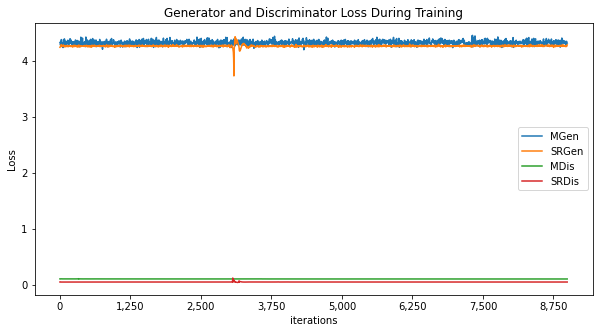

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(mGen_loss,label="MGen")
plt.plot(srGen_loss,label="SRGen")
plt.plot(mDis_loss,label="MDis")
plt.plot(srDis_loss,label="SRDis")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.gca().get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x*skip_steps), ',')))
plt.show()

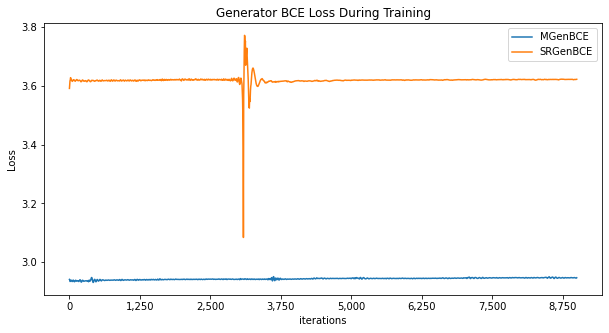

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator BCE Loss During Training")
plt.plot(mGen_bce,label="MGenBCE")
plt.plot(srGen_bce,label="SRGenBCE")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.gca().get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x*skip_steps), ',')))
plt.show()

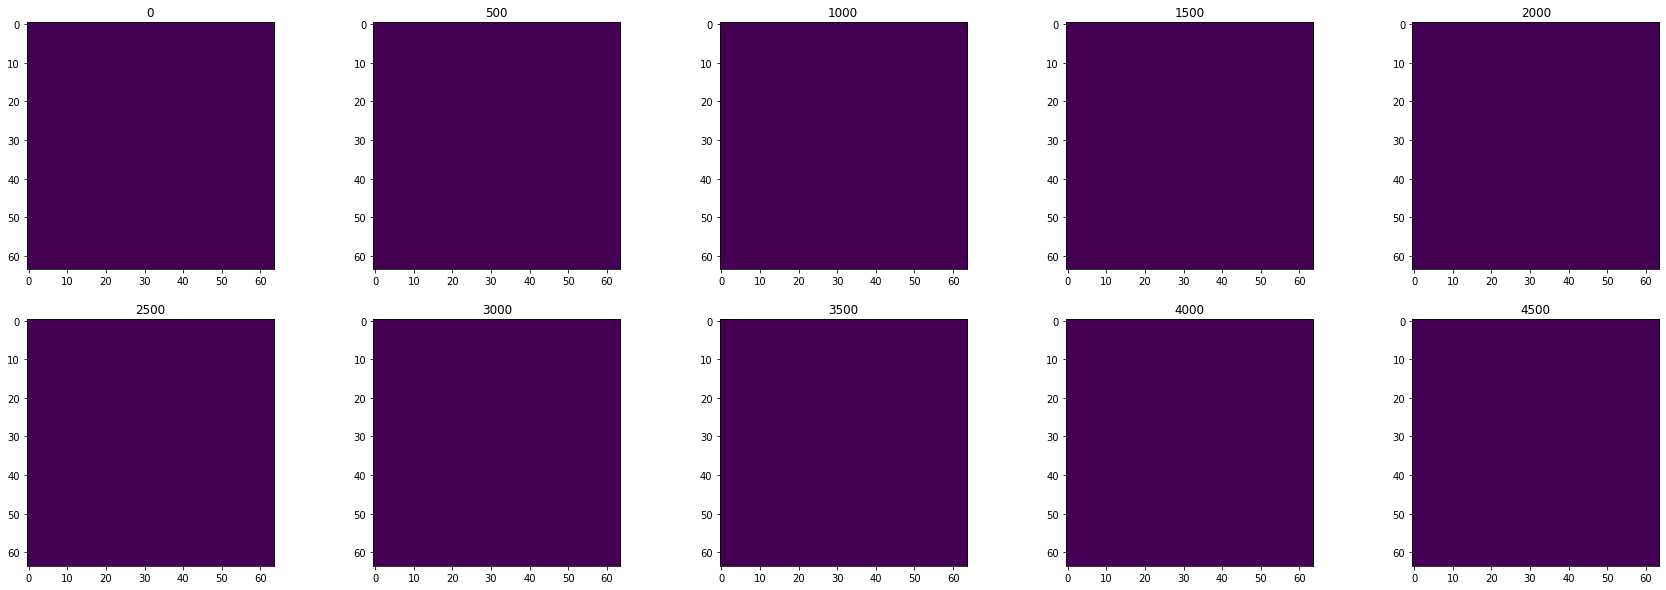

In [ ]:
plt.figure(figsize=(30,10))
for i in range(len(mimg_list)-10, len(mimg_list)):
  plt.subplot(2,10/2,i-(len(mimg_list)-10)+1)
  plt.imshow(mimg_list[i-(len(mimg_list)-10)].mean(0).mean(0))#, cmap='gray')
  plt.title('{}'.format((i-(len(mimg_list)-10))*500))
plt.show()

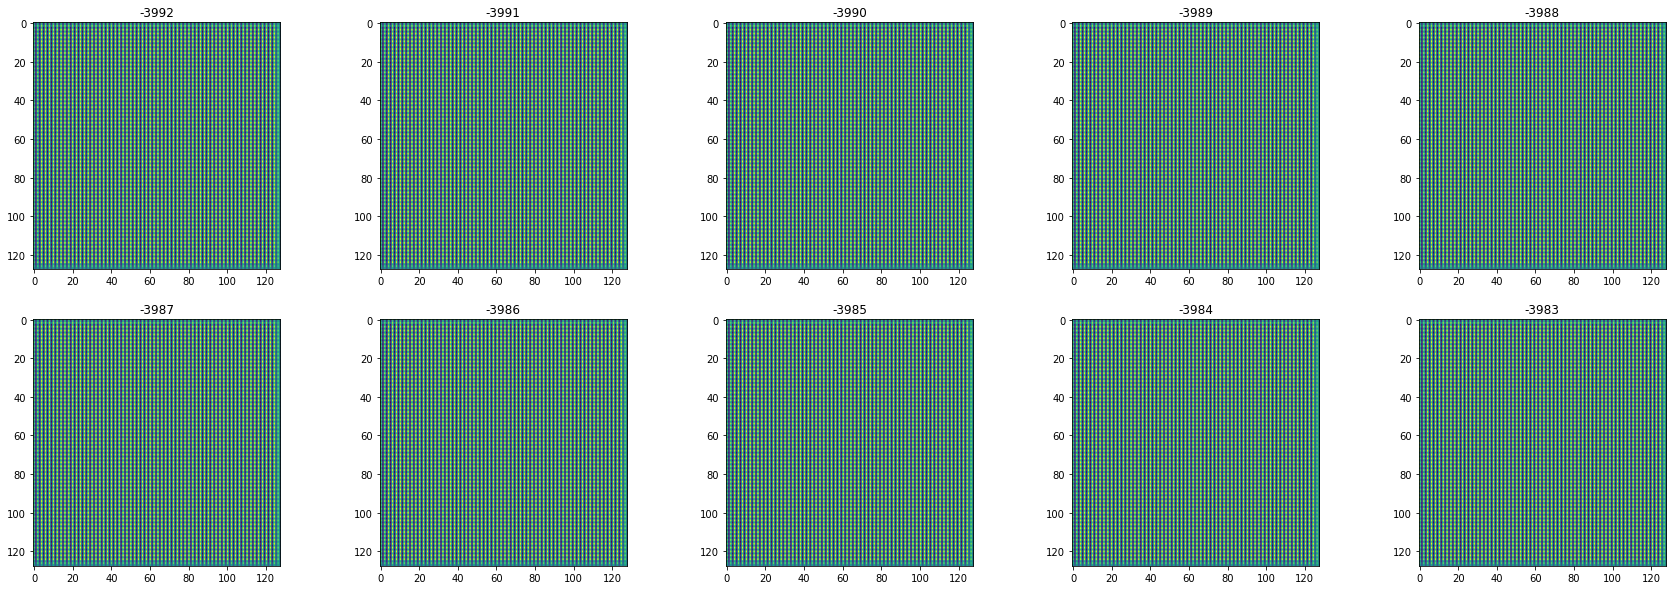

In [ ]:
plt.figure(figsize=(30,10))
for i in range(len(srimg_list)-10,len(srimg_list)):
  plt.subplot(2,10/2,i-(len(srimg_list)-10)+1)
  plt.imshow(srimg_list[i-(len(srimg_list)-10)].mean(0).mean(0))#, cmap='gray')
  plt.title('{}'.format(i-(len(srimg_list)-10)*500))
plt.show()

In [ ]:

print("Saving models at epoch: {}".format(num_epochs))
torch.save(mGen.state_dict(), '/content/drive/MyDrive/mGen-{}.pt'.format(num_epochs))
torch.save(mDis.state_dict(), '/content/drive/MyDrive/mDis-{}.pt'.format(num_epochs))
torch.save(srGen.state_dict(), '/content/drive/MyDrive/srGen-{}.pt'.format(num_epochs))
torch.save(srDis.state_dict(), '/content/drive/MyDrive/srDis-{}.pt'.format(num_epochs))


Saving models at epoch: 50
